In [2]:
import mlflow
import joblib

from mlflow import log_metric

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression



In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

def compute_metrics(y_test, y_test_pred):
    metrics = {}
    metrics["r2"] = r2_score(y_test, y_test_pred)
    metrics["rmse"] = mean_squared_error(y_test, y_test_pred, squared=False)
    metrics["mae"] = mean_absolute_error(y_test, y_test_pred)
    metrics["med"] = median_absolute_error(y_test, y_test_pred)
    return metrics



def plot_model_fit(y_test, y_test_pred,
                data_modality="Telemores", 
                data_set="Validation",
                smoker_status=None, 
                color="#55812C",
                model = "Elastic Net",
                title_override=None,
                fig_output_path="scatterplot_methylation.pdf"):
        
    metrics = compute_metrics(y_test, y_test_pred)

    # kind="reg" is not supported when using hue;
    # as a workaround we plot scatter separately.
    if smoker_status is not None:
        scatter = False
    else:
        scatter = True

    jointgrid = sns.jointplot(x=y_test, y=y_test_pred,
                                kind="reg",
                                truncate=False,
                                scatter=scatter,
                                fit_reg=True,
                                color=color,
                                xlim=(20, 70),
                                ylim=(20, 70))
    
    jointgrid.ax_joint.axline([0, 0], [1, 1], transform=jointgrid.ax_joint.transAxes,
                                linestyle="--", alpha=0.8, color='darkgray')

    if smoker_status is not None:
        sns.scatterplot(x=y_test, y=y_test_pred, hue=smoker_status, ax=jointgrid.ax_joint)
        sns.move_legend(jointgrid.ax_joint, "lower right")

    if title_override:
        plt.title(title_override)
    else:
        plt.title(f"{model} Model Fit for {data_modality} - {data_set} (N = {len(y_test)})")
    jointgrid.ax_joint.set_ylabel("Predicted Values")
    jointgrid.ax_joint.set_xlabel("True Value")
    t = plt.text(.05, .7,
                    'r²={:.3f}\nrmse={:.3f}\nmae={:.3f}\nmed={:.3f}\n'.format(
                        metrics["r2"], metrics["rmse"], metrics["mae"], metrics["med"]),
                    transform=jointgrid.ax_joint.transAxes)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor=color))
    jointgrid.fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    if fig_output_path:
        plt.savefig(fig_output_path, format="pdf", bbox_inches="tight")


In [4]:
EXPERIMENT_ID  = mlflow.create_experiment(f"telemores_models")

In [5]:
tissues_to_run = ["lung", "ovary"]

## Base model linear regression with just TL

2024/03/18 17:17:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


The number of sample in lung is 498


2024/03/18 17:17:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


Computing train / test metrics
The number of sample in colon is 517


2024/03/18 17:17:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Computing train / test metrics


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


The number of sample in ovary is 119


2024/03/18 17:18:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Computing train / test metrics


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


The number of sample in prostate is 162


2024/03/18 17:18:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Computing train / test metrics


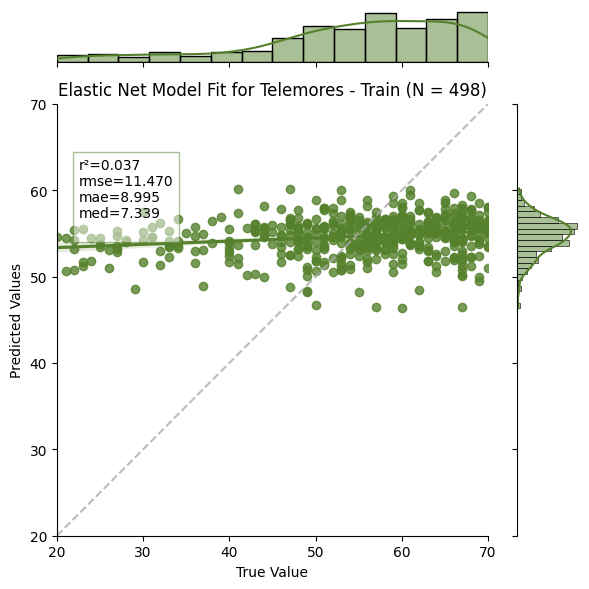

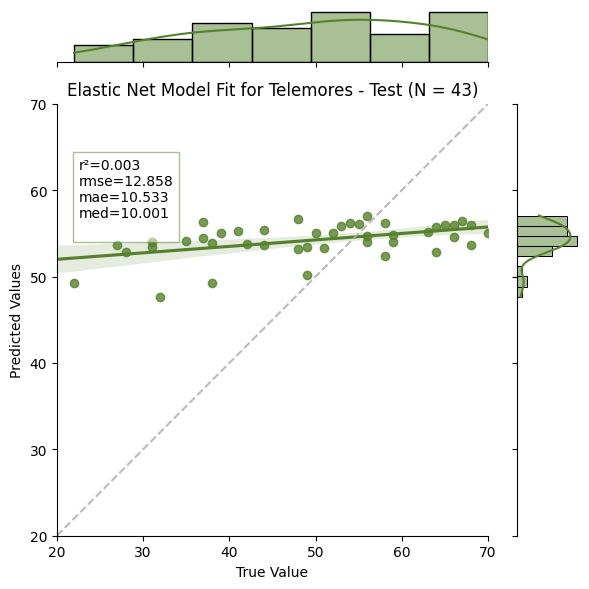

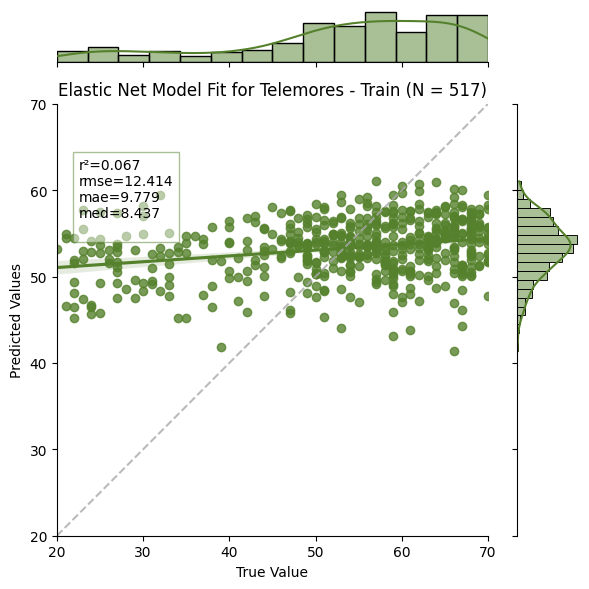

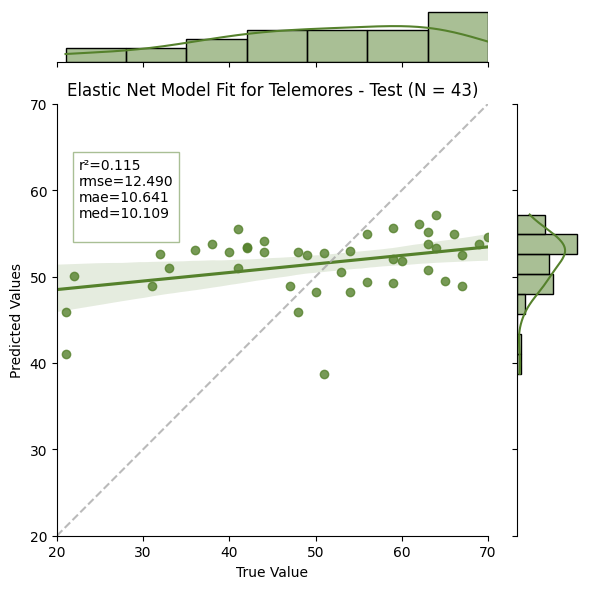

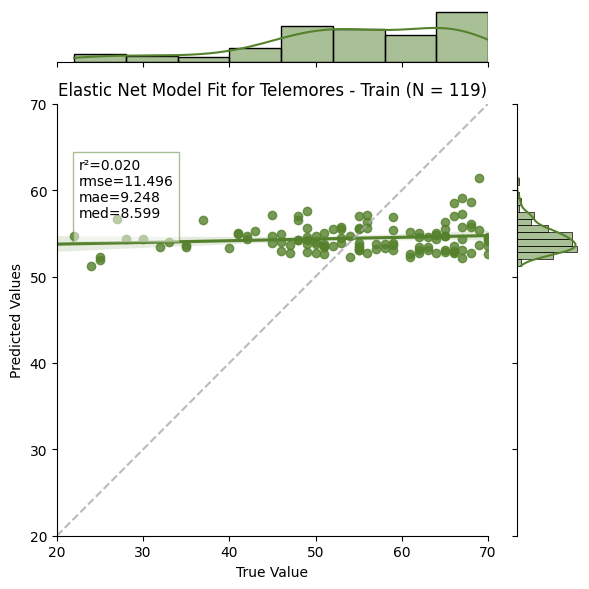

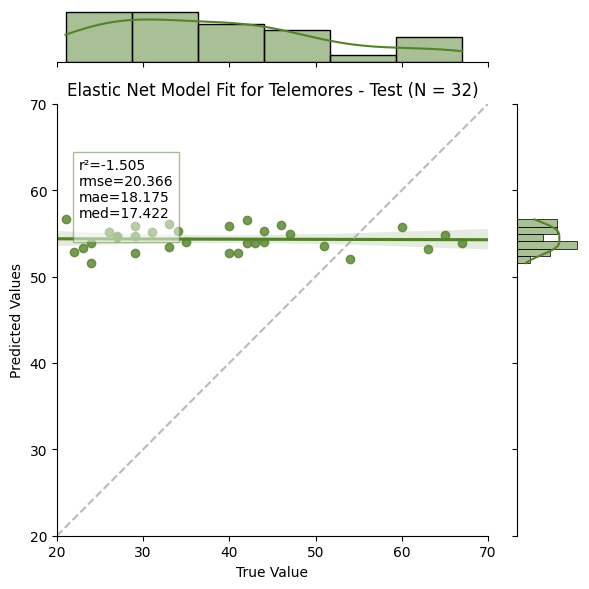

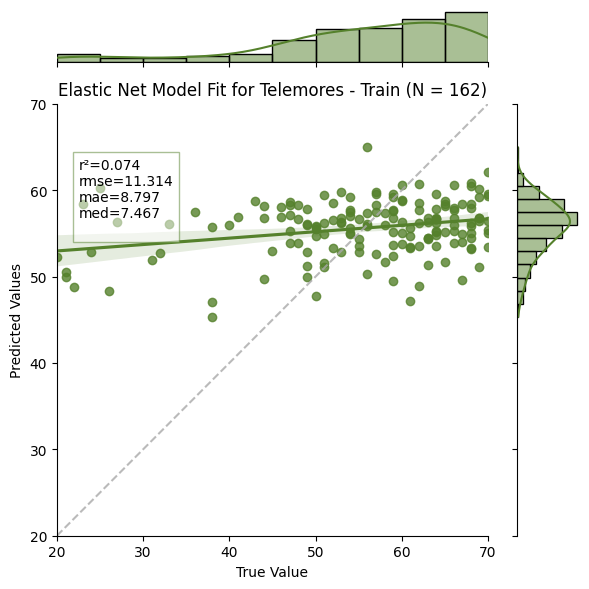

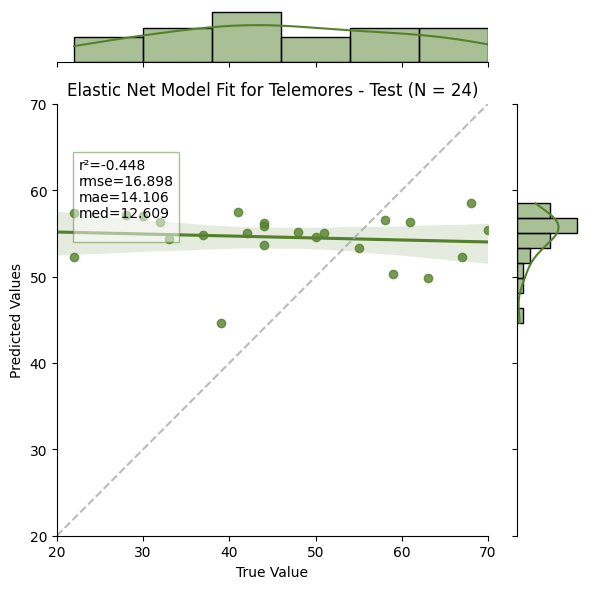

In [6]:
for tissue in tissues_to_run: 
    with mlflow.start_run(run_name = tissue + "_TQI", experiment_id = EXPERIMENT_ID) as _:

        #Load data
        tl_data = pd.read_csv(f"../../data/telemores_{tissue}.csv")

        # Subset Train and test data
        test_data = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")

        tl_data["sample_id"] = tl_data.CollaboratorSampleID.str.replace("-SM", "")
        tl_data_train = tl_data[~tl_data["sample_id"].isin(test_data["sample_id"])]
        tl_data_test = tl_data[tl_data["sample_id"].isin(test_data["sample_id"])]
        
        #Define folds for CV
        if tissue == "lung" or tissue == "colon_transverse": 
            n_folds = 10
        else: 
            n_folds = 5


        y = tl_data_train.AGE
        X = pd.DataFrame(tl_data_train.TQImean)


        age_bins = np.arange(18, 76, 5)
        y_bins = pd.cut(y, age_bins, labels=False)
        skf_gen = StratifiedKFold(n_folds).split(X, y_bins)

        folds = [[t[0], t[1]] for t in skf_gen]

        
        cv_scores = {}
        idx = 0
        model = LinearRegression()
        print(f"The number of sample in {tissue} is {X.shape[0]}")
        for cv_train_idx, cv_valid_idx in folds:
            X_fold_train, X_fold_valid = X.iloc[cv_train_idx], X.iloc[cv_valid_idx]
            y_fold_train, y_fold_valid = np.array(y)[cv_train_idx], np.array(y)[cv_valid_idx]

            
            model.fit(X_fold_train, y_fold_train)
            
            age_pred = model.predict(X_fold_valid)
            
            metrics_cv = compute_metrics(y_fold_valid, age_pred)
            for metric, value in metrics_cv.items(): 
                if metric not in cv_scores.keys() : 
                    cv_scores[metric] = np.empty(n_folds)   
                    cv_scores[metric][0] = value
                else: 
                    cv_scores[metric][idx] = value
            idx += 1

        
        # Save the cross-validation metrics
        for key, item in cv_scores.items(): 
            log_metric("cv_" + key + "_mean", cv_scores[key].mean())
            log_metric("cv_" + key + "_std",  cv_scores[key].std())

    
        y_test = tl_data_test.AGE
        X_test = pd.DataFrame(tl_data_test.TQImean)

        mlflow.sklearn.autolog() #autologs the model
        model.fit(X,y)

        print("Computing train / test metrics")
        y_train_pred = model.predict(X)
        metrics_train = compute_metrics(y, y_train_pred)
        train_prediction = pd.DataFrame({"ind": X.index, "true": y, "pred": y_train_pred})
        train_prediction.to_csv(f"../../results/8.telemore_models/{tissue}/1_train_prediction.csv")


        y_test_pred = model.predict(X_test)
        metrics_test = compute_metrics(y_test, y_test_pred)
        test_prediction = pd.DataFrame({"ind": X_test.index, "true": y_test, "pred": y_test_pred})
        test_prediction.to_csv(f"../../results/8.telemore_models/{tissue}/1_test_prediction.csv")

        for model_metric in metrics_train.keys(): 
            log_metric(model_metric + "_train", metrics_train[model_metric])
        
        for model_metric in metrics_test.keys(): 
            log_metric(model_metric + "_test", metrics_test[model_metric])

        #Plot model Fit
        plot_model_fit(y, 
                       y_train_pred, 
                       data_set="Train", 
                       fig_output_path= f"../../aging_notes/figures/8.telemore_models/1_{tissue}_tl_fit_train.pdf")


        plot_model_fit(y_test, 
                    y_test_pred, 
                    data_set="Test", 
                    fig_output_path= f"../../aging_notes/figures/8.telemore_models/1_{tissue}_tl_fit_test.pdf")
        
    
        joblib.dump(model, f'../../results/8.telemore_models/{tissue}/1.pipeline.pkl', compress = 1)
    

## Compare with the null model

Compare a model built using metadata and TQI with the same model without TQI

In [7]:
tl_data.head()

,Unnamed: 0,CollaboratorParticipantID,Sample.ID.for.Public.Release,CollaboratorSampleID,Container,TissueSiteDetail,TQImean,AGE,BMI,SEX,RACE,SmokerStatus,sample_id
0,1,GTEX-111CU,GTEX-111CU-1526-SM-AOZL4,GTEX-111CU-1526-SM,CO-16290140,Prostate,0.71,57,33.57,1,3,smoker,GTEX-111CU-1526
1,2,GTEX-111FC,GTEX-111FC-2026-SM-AHP82,GTEX-111FC-2026-SM,CO-15972664,Prostate,1.03,61,25.06,1,3,non-smoker,GTEX-111FC-2026
2,3,GTEX-117XS,GTEX-117XS-1826-SM-AKJD6,GTEX-117XS-1826-SM,CO-16096209,Prostate,1.00,64,30.68,1,3,ex-smoker,GTEX-117XS-1826
3,4,GTEX-117YW,GTEX-117YW-1426-SM-AKIIH,GTEX-117YW-1426-SM,CO-16095539,Prostate,1.01,58,29.83,1,3,ex-smoker,GTEX-117YW-1426
4,5,GTEX-1192X,GTEX-1192X-2126-SM-AHOYT,GTEX-1192X-2126-SM,CO-15972659,Prostate,1.30,55,24.49,1,3,smoker,GTEX-1192X-2126


In [8]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

anovas = {}

for tissue in tissues_to_run: 
    #Load data
    tl_data = pd.read_csv(f"../../data/telemores_{tissue}.csv")
    tl_data = tl_data.dropna(subset =["SmokerStatus"])
    
    #Define folds for CV
    if tissue == "lung" or tissue == "colon_transverse": 
        n_folds = 5
    else: 
        n_folds = 5


    model = ols('AGE ~ TQImean +  SEX + BMI + SmokerStatus + RACE', data=tl_data).fit()
    anova = anova_lm(model)

    anovas[tissue] = anova


In [9]:
anovas

{'lung':                  df        sum_sq      mean_sq          F        PR(>F)
 SmokerStatus    3.0   2729.230674   909.743558   6.930171  1.428783e-04
 TQImean         1.0   3486.730627  3486.730627  26.560935  3.782132e-07
 SEX             1.0     41.376884    41.376884   0.315197  5.747786e-01
 BMI             1.0     41.544795    41.544795   0.316477  5.740039e-01
 RACE            1.0      2.565579     2.565579   0.019544  8.888790e-01
 Residual      465.0  61041.891821   131.272886        NaN           NaN,
 'colon':                  df        sum_sq      mean_sq          F        PR(>F)
 SmokerStatus    3.0   3508.255631  1169.418544   7.708173  4.893360e-05
 TQImean         1.0   6219.570366  6219.570366  40.996038  3.688533e-10
 SEX             1.0    238.238116   238.238116   1.570337  2.107786e-01
 BMI             1.0    163.386142   163.386142   1.076953  2.999115e-01
 RACE            1.0     20.647104    20.647104   0.136095  7.123603e-01
 Residual      472.0  71607.82764